In [1]:
#####
# Packages
##### 

import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow import keras

## I. Read in dataset 

In [2]:
sepdatafull = pd.read_csv('wikihowSep.csv')

In [3]:
sepdata = sepdatafull[:2000]

In [4]:
sepdata.shape

(2000, 5)

### Examine for NAs 

In [11]:
sepdata.head(5)
# Notice how we have 4 columns: 
# 'overview': the full summary based on the wikihow article 
# 'headline': the "summary" for the paragraph in 'text' column 
# 'text': the actual text of the paragraph 
# 'sectionLabel': section label of the paragraph 
# 'title': the title of which the paragraph belongs to. 

# wikihowSep (downloaded here: https://github.com/mahnazkoupaee/WikiHow-Dataset) is the same file as 
# wikihowAll, except separated by paragraph. 

# Given the length of the documents under wikihowAll, we opted for a shorter summary model to work with where we can 
# take paragraphs, and attempt to generate the headline for the paragraph instead. 

,overview,headline,text,sectionLabel,title
0,So you're a new or aspiring artist and your c...,\nSell yourself first.,"Before doing anything else, stop and sum up y...",Steps,How to Sell Fine Art Online
1,"If you want to be well-read, then, in the wor...",\nRead the classics before 1600.,Reading the classics is the very first thing ...,Reading the Classics,How to Be Well Read
2,So you're a new or aspiring artist and your c...,\nJoin online artist communities.,Depending on what scale you intend to sell yo...,Steps,How to Sell Fine Art Online
3,So you're a new or aspiring artist and your c...,\nMake yourself public.,Get yourself out there as best as you can by ...,Steps,How to Sell Fine Art Online
4,So you're a new or aspiring artist and your c...,\nBlog about your artwork.,"Given the hundreds of free blogging websites,...",Steps,How to Sell Fine Art Online


In [12]:
# are there any NA's that we should drop? 
# Note here that we are only concerned about the 3 columns: headline, text, and title 

sepdata_v1 = sepdata.dropna(subset=['headline','text','title'], axis=0).reset_index(drop=True) 
len(sepdata_v1) #yes, we see some NA rows 

1902

In [13]:
sepdata_v1.head()

,overview,headline,text,sectionLabel,title
0,So you're a new or aspiring artist and your c...,\nSell yourself first.,"Before doing anything else, stop and sum up y...",Steps,How to Sell Fine Art Online
1,"If you want to be well-read, then, in the wor...",\nRead the classics before 1600.,Reading the classics is the very first thing ...,Reading the Classics,How to Be Well Read
2,So you're a new or aspiring artist and your c...,\nJoin online artist communities.,Depending on what scale you intend to sell yo...,Steps,How to Sell Fine Art Online
3,So you're a new or aspiring artist and your c...,\nMake yourself public.,Get yourself out there as best as you can by ...,Steps,How to Sell Fine Art Online
4,So you're a new or aspiring artist and your c...,\nBlog about your artwork.,"Given the hundreds of free blogging websites,...",Steps,How to Sell Fine Art Online


In [14]:
# Therefore, how many true titles do we have? 
len(sepdata_v1['title'].unique()) #only 211,825 

291

In [15]:
# It doesn't quite matter for us since we are trying to predict headline and not the title, 
# but out of curiosity, how many paragraphs on average belong to each title? 
np.nanmean(sepdata_v1[['title','text']].groupby('title').agg('count')['text'].values) 
# Roughly 6-7 paragraphs per title 

6.536082474226804

Text(0.5, 1.0, 'Paragraphs per Article (title)')

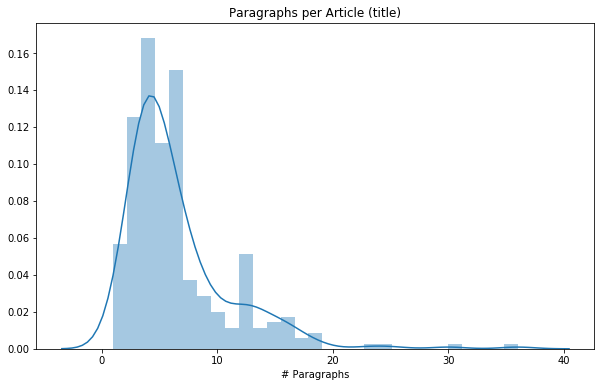

In [16]:
%matplotlib inline 
import seaborn as sns
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(1,1, figsize = (10,6)) 
sns.distplot(sepdata_v1[['title','text']].groupby('title').agg('count')['text'].values, 
            ax=axes, axlabel = '# Paragraphs').set_title('Paragraphs per Article (title)')
# majority of our paragarphsgenerally 

## II. Begin cleaning text of paragraphs 

In [ ]:
# Define a text cleaner 
# Drawn heavily with reference from here 
# https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

In [17]:
import re #for regex search purposes          
from nltk.corpus import stopwords #stopwords that are provided to us via nltk 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import math

In [18]:
# List of contractions that we will map to 

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [19]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    # Step 0: Convert to string in case a float or int is found.
    newString = str(text)
    # Step 1: Lower case the text 
    newString = newString.lower()
    # Step 2: Get rid of commas
    newString = re.sub(r'\([^)]*\)', '', newString)
    # Step 3: Get rid of quotations 
    newString = re.sub('"','', newString)
    # Step 4: get rid of contractions with our contraction mapping 
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])  
    # Step 5: get rid of the \n stuff 
    newString = re.sub(r"'s\n","",newString)
    # Step 6: anything that is a number, get rid of it 
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    # Step 7: Tokenize everything first and keep the words that are not stop words 
    # Also keep only words that are greater than or equal to 3 characters long 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3: #removing short words
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [20]:
# repeat the same step for the headlines, but with some variation on cleaning 

def headline_cleaner(text):
    # Step 0: Convert to string in case a float or int is found.
    newString = str(text)
    # Step 1: remove quotations 
    newString = re.sub('"','', newString)
    # Step 2: look up contractions 
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) 
    # Step 3: Get rid of the \n stuff 
    newString = re.sub(r"'s\n","",newString)
    # Step 4: Get rid of numbers or anything not in the alphabet
    newString = re.sub("[^a-zA-Z]", " ", newString)
    # Step 5: Lower case 
    newString = newString.lower()
    tokens=newString.split()
    # Step 6: keep words that are greater than 1 character long 
    remaining=[]
    for i in tokens:
        if len(i)>1:                                 
            remaining.append(i) 
    return (" ".join(remaining)).strip()

In [21]:
sepdata_v1.shape

(1902, 5)

In [22]:
clean_data = pd.DataFrame()

clean_data['text'] = sepdata_v1['text'].apply(text_cleaner)

clean_data['headline'] = sepdata_v1['headline'].apply(headline_cleaner)

In [23]:
clean_data.shape

(1902, 2)

In [24]:
sepdata['text'][0]
#Preprocessing has made the text difficult for humans to understand (let alone summarize). Maybe that's the language of the machine. Good luck buddy!


" Before doing anything else, stop and sum up yourself as an artist. Now, think about how to translate that to an online profile. Be it the few words, Twitter allows you or an entire page of indulgence that your own website would allow you. Bring out the most salient features of your creativity, your experience, your passion, and your reasons for painting. Make it clear to readers why you are an artist who loves art, produces high quality art, and is a true champion of art. If you're not great with words, find a friend who can help you with this really important aspect of selling online – the establishment of your credibility and reliability.;\n"

In [25]:
embeddings_index = {}
f = open('data/glove/glove.6B/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [26]:
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [27]:

def doc2seq(texts, MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM):
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post')
    
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return data, embedding_matrix, word_index

In [28]:
MAX_NB_WORDS = 30000
MAX_TEXT_LENGTH = 100
EMBEDDING_DIM = 100
data = clean_data.text

x_data, encoder_emb, x_word_index = doc2seq(data, MAX_NB_WORDS, MAX_TEXT_LENGTH, EMBEDDING_DIM)

Found 10204 unique tokens.


In [29]:
encoder_emb[1]

array([ 0.082528  , -0.07529   ,  0.014696  , -0.31123999, -0.24006   ,
       -0.48255   ,  0.13352001,  0.043161  ,  0.19054   , -0.52213001,
       -0.12503999,  0.029079  ,  0.34909001,  0.42934999,  0.66658998,
       -0.28475001,  0.38381001,  0.33901   , -0.57170999,  0.11767   ,
        0.20123   , -0.79966003,  0.82827997,  0.59539998, -0.25487   ,
        0.024701  , -0.14971   , -0.36822   ,  0.55805999, -0.18942   ,
        0.2369    ,  0.73505998, -0.082499  , -0.58811998, -0.085873  ,
        0.60373998,  0.2383    ,  0.44659001, -0.074284  , -0.33467001,
       -0.26497999, -0.32317999, -0.11407   , -0.67289001,  0.033642  ,
       -0.34303999,  0.54404002, -0.5819    ,  0.23615   , -1.07379997,
        0.21622001, -0.50559002,  0.16373   ,  1.12769997, -0.3188    ,
       -2.48379993, -0.17653   , -0.87256002,  1.55710006,  0.62638003,
       -0.63165998,  1.33299994, -0.61523002,  0.14067   ,  1.05110002,
        0.40579   , -0.11776   , -0.077961  ,  0.058356  , -0.66

In [31]:
MAX_NB_WORDS = 30000
MAX_HEADLINE_LENGTH = 30
EMBEDDING_DIM = 100
data = clean_data.headline

y_data, decoder_emb, y_word_index = doc2seq(data, MAX_NB_WORDS, MAX_HEADLINE_LENGTH, EMBEDDING_DIM)

Found 2946 unique tokens.


In [32]:
y_data.shape

(1902, 30)

In [33]:
y_data[0]

array([874,  37, 104,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)

In [34]:
decoder_emb.shape

(2947, 100)

In [35]:
decoder_emb[0] #embedding for unknown

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [36]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, TimeDistributed, Bidirectional, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from attention_keras.layers.attention import AttentionLayer

from tensorflow.keras import backend as K 
K.clear_session() 
hidden_units = 200 #this is 600 in the paper. To be changed later.


In [37]:
len(y_word_index) + 1

2947

In [38]:
enc_embedding_layer = Embedding(len(x_word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[encoder_emb],
                            input_length=MAX_TEXT_LENGTH,
                            trainable=False,
                            name='EncoderEmbeddingLayer')

W1105 20:03:50.100099 4541410624 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [39]:
dec_embedding_layer = Embedding(len(y_word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[decoder_emb],
                            input_length=MAX_HEADLINE_LENGTH,
                            trainable=False,
                            name='DecoderEmbeddingLayer')

In [43]:
# Encoder 

# Encoder input 
# 2D (sequence_length, None), where sequence length is the MAX_LEN unified by padding in preprocessing
encoder_inputs = Input(shape=(MAX_TEXT_LENGTH,), name="EncoderInput") 
enc_emb = enc_embedding_layer(encoder_inputs) 


#LSTM 1 
encoder_lstm1 = LSTM(hidden_units,return_sequences=True,return_state=True, name='EncLSTM1') 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(hidden_units,return_sequences=True,return_state=True, name='EncLSTM2') 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(hidden_units, return_state=True, return_sequences=True, name='EncLSTM3') 
encoder_output3, state_h3, state_c3= encoder_lstm3(encoder_output2) 

#LSTM 4 
encoder_lstm4=LSTM(hidden_units, return_state=True, return_sequences=True, name='EncLSTM4') 
encoder_outputs, state_h, state_c= encoder_lstm4(encoder_output3) 

In [44]:
# Decoder 

decoder_inputs = Input(shape=(None,), name = 'DecoderInput') 
#dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_embedding_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, name='DecLSTM1') 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(len(y_word_index)+1, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 


In [45]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
EncoderEmbeddingLayer (Embeddin (None, 100, 100)     1020500     EncoderInput[0][0]               
__________________________________________________________________________________________________
EncLSTM1 (LSTM)                 [(None, 100, 200), ( 240800      EncoderEmbeddingLayer[2][0]      
__________________________________________________________________________________________________
EncLSTM2 (LSTM)                 [(None, 100, 200), ( 320800      EncLSTM1[0][0]                   
______________________________________________________________________________________________

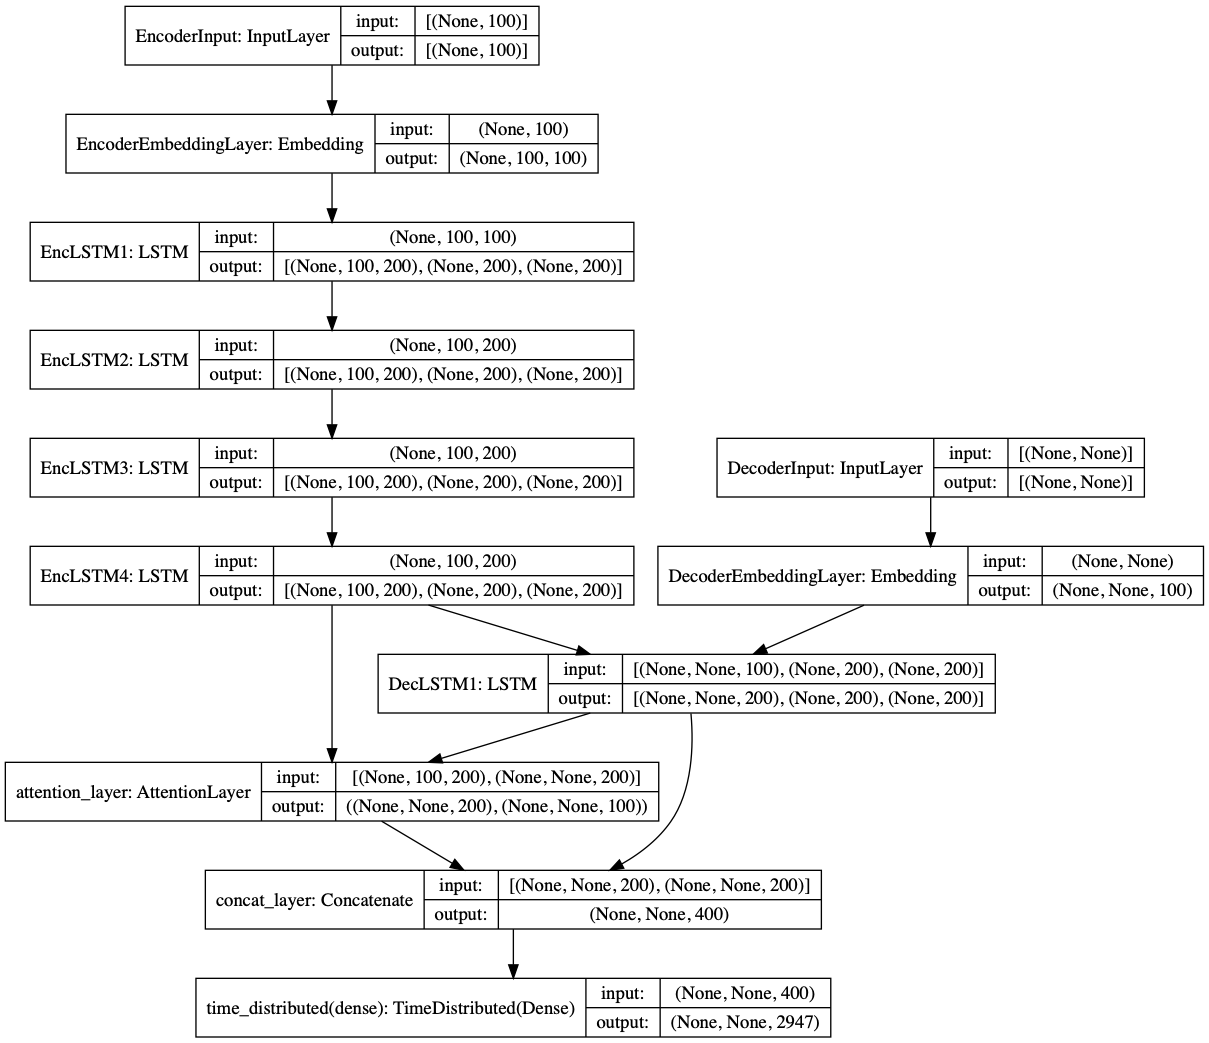

In [65]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'
)

In [68]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [72]:
history=model.fit([x_data,[0] + y_data], 
                  y_data,
                  epochs=1,
                  batch_size=50#, 
                  #validation_data=([sample_x_val,sample_y_val[:,:-1]], sample_y_val.reshape(sample_y_val.shape[0],sample_y_val.shape[1], 1)[:,1:])
                 )

1902/1902 [==============================] - 145s 76ms/sample - loss: 2.9292
